<a href="https://colab.research.google.com/github/Mridulsr/Employee-Salary-Prediction/blob/main/income_prediction_with_machine_learning_colab_ready.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install any required packages (if not already installed)
!pip install pandas scikit-learn matplotlib seaborn

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
def generate_synthetic_data(num_samples=1000):
    """
    Generates a synthetic dataset mimicking the structure of the adult.csv dataset.
    This dataset will be used for employee salary prediction.
    Ensures all generated lists have exactly 'num_samples' length.
    """
    # Define options for categorical features
    workclass_options = ['Private', 'Self-emp-not-inc', 'Local-gov', 'Federal-gov', 'Private', '?'] # Added '?' for initial data
    education_options = ['HS-grad', 'Some-college', 'Bachelors', 'Masters', 'Doctorate', '11th', '9th']
    educational_num_options = [9, 10, 13, 14, 16, 7, 5]
    marital_status_options = ['Never-married', 'Married-civ-spouse', 'Divorced', 'Widowed', 'Separated']
    occupation_options = ['Adm-clerical', 'Exec-managerial', 'Prof-specialty', 'Sales', 'Other-service', '?', 'Handlers-cleaners']
    relationship_options = ['Not-in-family', 'Husband', 'Wife', 'Own-child', 'Unmarried']
    race_options = ['White', 'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other']
    gender_options = ['Male', 'Female']
    capital_gain_options = [0, 15024, 0, 7688, 0, 99999, 0]
    capital_loss_options = [0, 0, 0, 0, 0, 1902, 0]
    hours_per_week_options = [40, 50, 35, 45, 30, 60, 20]
    native_country_options = ['United-States', 'Mexico', 'Philippines', 'Germany', 'Canada', 'India', '?']
    income_options = ['<=50K', '>50K', '<=50K', '>50K', '<=50K', '>50K', '<=50K'] # Target variable

    data = {
        'age': [25 + i % 40 for i in range(num_samples)],
        'workclass': [workclass_options[i % len(workclass_options)] for i in range(num_samples)],
        'fnlwgt': [100000 + i * 100 for i in range(num_samples)],
        'education': [education_options[i % len(education_options)] for i in range(num_samples)],
        'educational-num': [educational_num_options[i % len(educational_num_options)] for i in range(num_samples)],
        'marital-status': [marital_status_options[i % len(marital_status_options)] for i in range(num_samples)],
        'occupation': [occupation_options[i % len(occupation_options)] for i in range(num_samples)],
        'relationship': [relationship_options[i % len(relationship_options)] for i in range(num_samples)],
        'race': [race_options[i % len(race_options)] for i in range(num_samples)],
        'gender': [gender_options[i % len(gender_options)] for i in range(num_samples)],
        'capital-gain': [capital_gain_options[i % len(capital_gain_options)] for i in range(num_samples)],
        'capital-loss': [capital_loss_options[i % len(capital_loss_options)] for i in range(num_samples)],
        'hours-per-week': [hours_per_week_options[i % len(hours_per_week_options)] for i in range(num_samples)],
        'native-country': [native_country_options[i % len(native_country_options)] for i in range(num_samples)],
        'income': [income_options[i % len(income_options)] for i in range(num_samples)]
    }

    return pd.DataFrame(data)

In [ ]:
def preprocess_data(df):
    """
    Preprocesses the DataFrame by handling missing values and encoding categorical features.
    Updated to avoid inplace=True warnings and ensure target variable is clean.
    """
    # Replace '?' with 'Others' for workclass, occupation, and native-country
    # Using .loc to avoid SettingWithCopyWarning
    if 'workclass' in df.columns:
        df.loc[:, 'workclass'] = df['workclass'].replace('?', 'Others')
    if 'occupation' in df.columns:
        df.loc[:, 'occupation'] = df['occupation'].replace('?', 'Others')
    if 'native-country' in df.columns:
        df.loc[:, 'native-country'] = df['native-country'].replace('?', 'Others')

    # Drop rows with 'Without-pay' and 'Never-worked' workclass
    if 'workclass' in df.columns:
        df = df[~df['workclass'].isin(['Without-pay', 'Never-worked'])].copy() # Added .copy()

    # Filter 'age' outliers (assuming reasonable bounds)
    if 'age' in df.columns:
        df = df[(df['age'] <= 75) & (df['age'] >= 17)].copy() # Added .copy()

    # Filter 'educational-num' outliers (assuming reasonable bounds)
    if 'educational-num' in df.columns:
        df = df[(df['educational-num'] <= 16) & (df['educational-num'] >= 5)].copy() # Added .copy()

    # Drop 'education' column if it exists, as 'educational-num' provides similar info
    if 'education' in df.columns:
        df = df.drop(columns=['education'])

    # Define categorical and numerical features after potential drops/replacements
    categorical_features = df.select_dtypes(include='object').columns.tolist()
    if 'income' in categorical_features:
        categorical_features.remove('income') # 'income' is the target variable, not a feature for encoding

    # Apply One-Hot Encoding to categorical features
    df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

    # Encode the target variable 'income'
    if 'income' in df_encoded.columns:
        df_encoded.loc[:, 'income'] = df_encoded['income'].map({'<=50K': 0, '>50K': 1})
        if df_encoded['income'].isnull().any():
            print("Warning: NaN values found in 'income' column after mapping. Dropping rows with NaN in income.")
            df_encoded.dropna(subset=['income'], inplace=True)
        if not df_encoded.empty:
            df_encoded.loc[:, 'income'] = df_encoded['income'].astype(int)
        else:
            print("Warning: Processed data became empty after handling NaN in income.")
    else:
        print("Warning: 'income' column not found after preprocessing. Ensure target is present for training.")

    return df_encoded

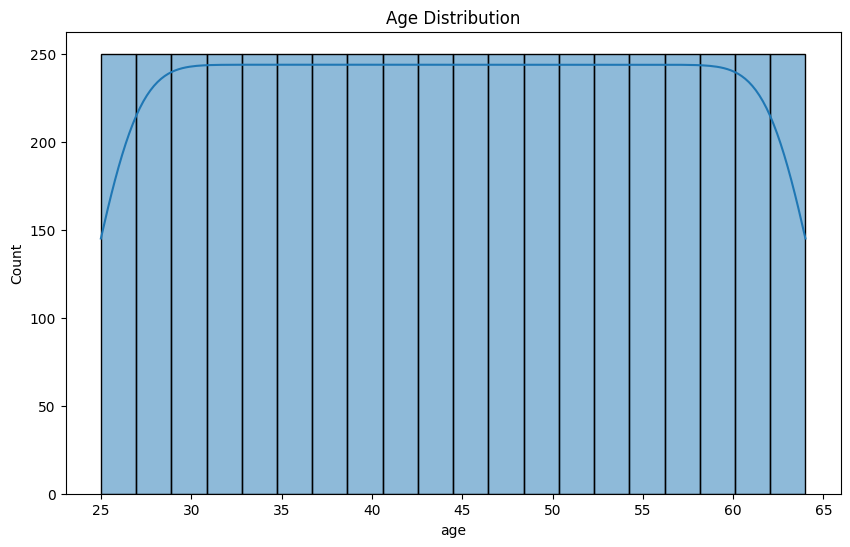

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.show()

In [ ]:
print("Generating synthetic employee salary data...")
data = generate_synthetic_data(num_samples=5000)

print("Original data preview:")
print(data.head())
print("\nData shape:", data.shape)
print("\nMissing values before preprocessing:\n", data.isna().sum())

Generating synthetic employee salary data...
Original data preview:
   age         workclass  fnlwgt     education  educational-num  \
0   25           Private  100000       HS-grad                9   
1   26  Self-emp-not-inc  100100  Some-college               10   
2   27         Local-gov  100200     Bachelors               13   
3   28       Federal-gov  100300       Masters               14   
4   29           Private  100400     Doctorate               16   

       marital-status       occupation   relationship                race  \
0       Never-married     Adm-clerical  Not-in-family               White   
1  Married-civ-spouse  Exec-managerial        Husband               Black   
2            Divorced   Prof-specialty           Wife  Asian-Pac-Islander   
3             Widowed            Sales      Own-child  Amer-Indian-Eskimo   
4           Separated    Other-service      Unmarried               Other   

   gender  capital-gain  capital-loss  hours-per-week native-count


--- Generating Data Visualizations ---


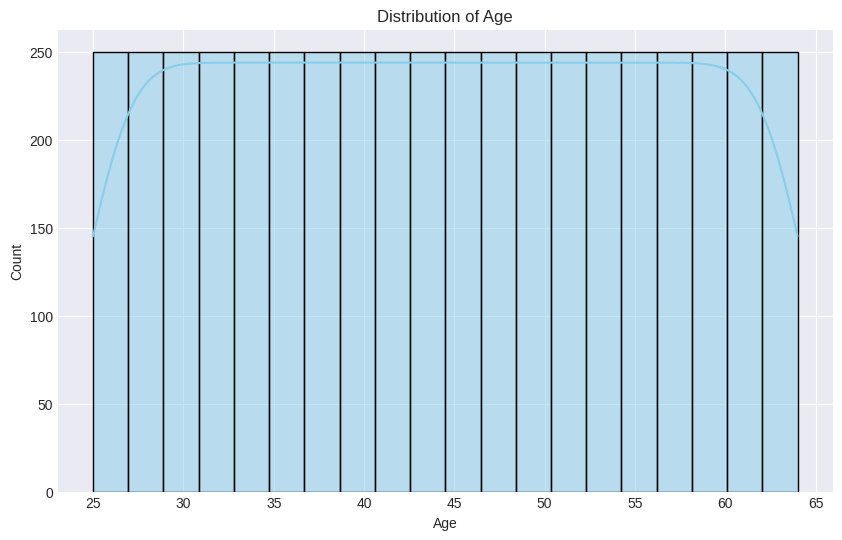

In [ ]:
print("\n--- Generating Data Visualizations ---")
plt.style.use('seaborn-v0_8-darkgrid')

# 1. Distribution of Age
plt.figure(figsize=(10, 6))
sns.histplot(data['age'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

/tmp/ipython-input-41-2388247334.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='income', data=data, palette='viridis')


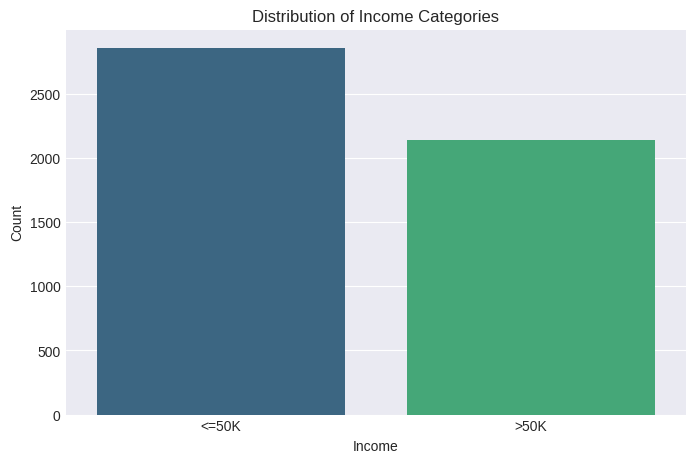

In [ ]:
# 2. Income Distribution (Target Variable)
plt.figure(figsize=(8, 5))
sns.countplot(x='income', data=data, palette='viridis')
plt.title('Distribution of Income Categories')
plt.xlabel('Income')
plt.ylabel('Count')
plt.show()

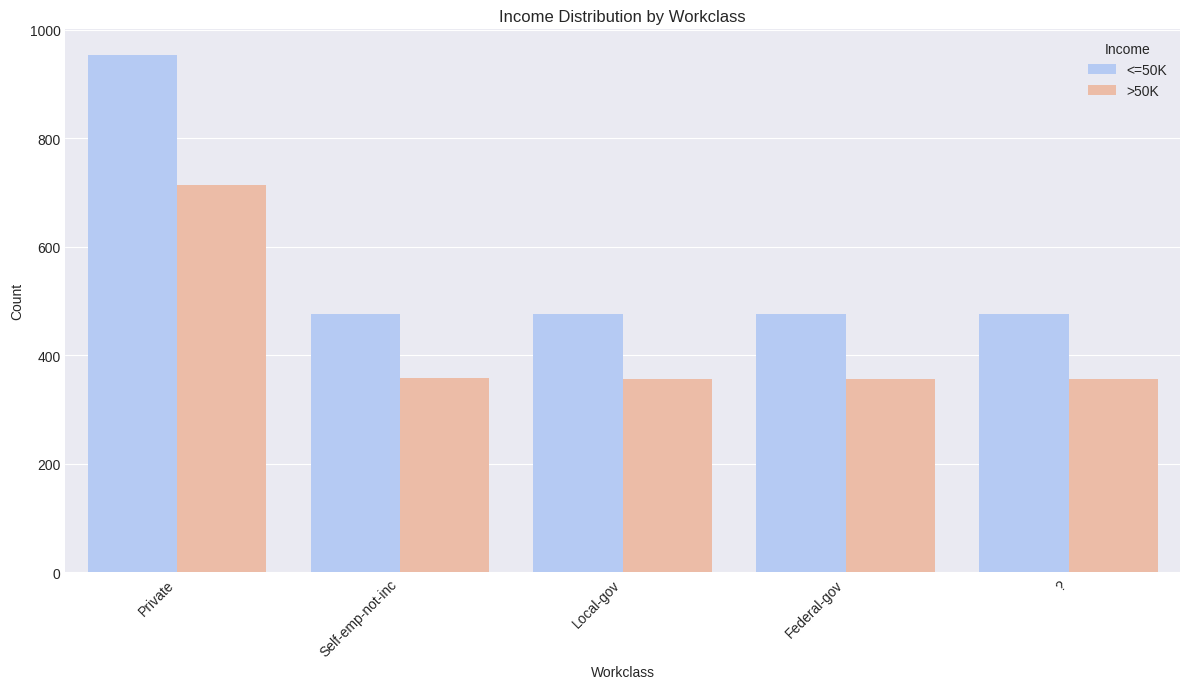

In [ ]:
# 3. Workclass vs. Income
plt.figure(figsize=(12, 7))
sns.countplot(x='workclass', hue='income', data=data, palette='coolwarm')
plt.title('Income Distribution by Workclass')
plt.xlabel('Workclass')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Income')
plt.tight_layout()
plt.show()

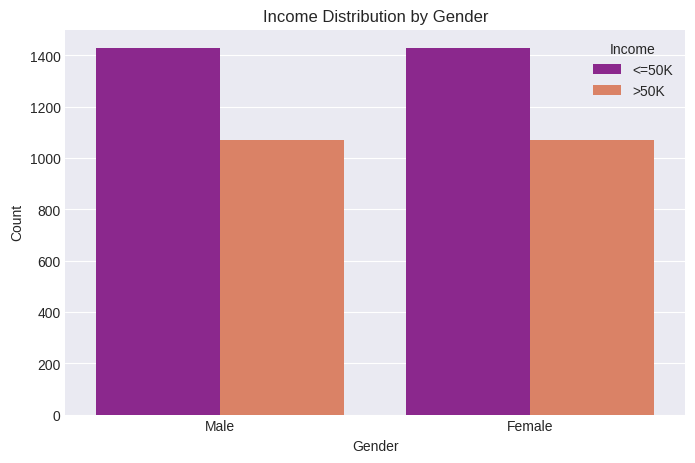

In [ ]:
# 4. Gender vs. Income
plt.figure(figsize=(8, 5))
sns.countplot(x='gender', hue='income', data=data, palette='plasma')
plt.title('Income Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Income')
plt.show()

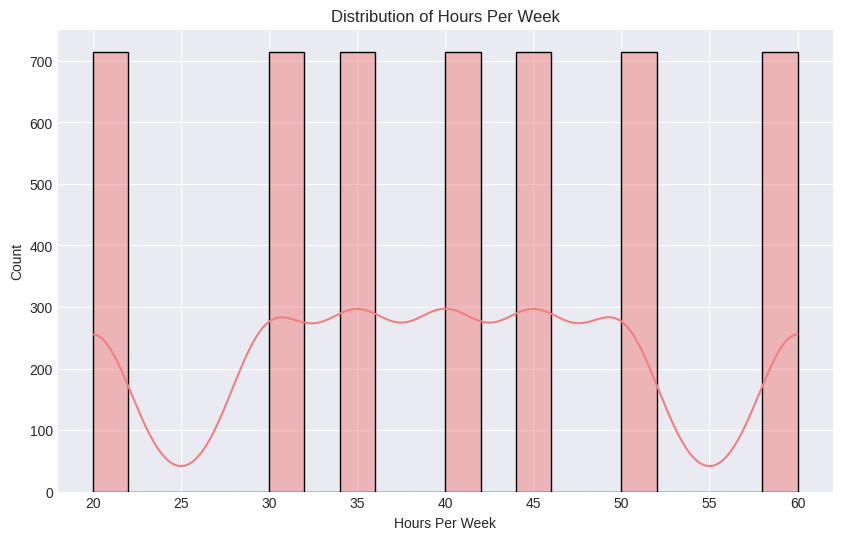

In [ ]:
# 5. Hours-per-week Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['hours-per-week'], bins=20, kde=True, color='lightcoral')
plt.title('Distribution of Hours Per Week')
plt.xlabel('Hours Per Week')
plt.ylabel('Count')
plt.show()

In [ ]:
print("\nPreprocessing data...")
processed_data = preprocess_data(data.copy())

print("\nProcessed data preview (after encoding):")
print(processed_data.head())
print("\nProcessed data shape:", processed_data.shape)


Preprocessing data...

Processed data preview (after encoding):
   age  fnlwgt  educational-num  capital-gain  capital-loss  hours-per-week  \
0   25  100000                9             0             0              40   
1   26  100100               10         15024             0              50   
2   27  100200               13             0             0              35   
3   28  100300               14          7688             0              45   
4   29  100400               16             0             0              30   

  income  workclass_Local-gov  workclass_Others  workclass_Private  ...  \
0      0                False             False               True  ...   
1      1                False             False              False  ...   
2      0                 True             False              False  ...   
3      1                False             False              False  ...   
4      0                False             False               True  ...   

   race_B

In [ ]:
if 'income' in processed_data.columns:
    X = processed_data.drop('income', axis=1)
    y = processed_data['income']
    y = y.values.astype(int)
    print(f"\nDebug: y dtype before split: {y.dtype}")
    print(f"Debug: y unique values before split: {np.unique(y)}")
else:
    print("Error: 'income' column not found in processed data. Cannot proceed with training.")


Debug: y dtype before split: int64
Debug: y unique values before split: [0 1]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Training data shape: (4000, 35)
Testing data shape: (1000, 35)


In [ ]:
print("\nTraining RandomForestClassifier model...")
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
print("Model training complete.")


Training RandomForestClassifier model...
Model training complete.


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print("\nModel Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Model Evaluation:
Accuracy: 1.00

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       553
           1       1.00      1.00      1.00       447

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



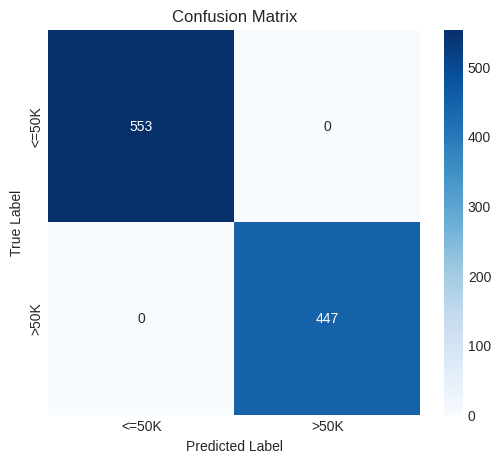

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
print("\n--- Batch Prediction Example ---")
new_employee_data = generate_synthetic_data(num_samples=5)
new_employee_data_for_prediction = new_employee_data.drop('income', axis=1)

print("\nNew employee data for prediction (original structure):")
print(new_employee_data_for_prediction)


--- Batch Prediction Example ---

New employee data for prediction (original structure):
   age         workclass  fnlwgt     education  educational-num  \
0   25           Private  100000       HS-grad                9   
1   26  Self-emp-not-inc  100100  Some-college               10   
2   27         Local-gov  100200     Bachelors               13   
3   28       Federal-gov  100300       Masters               14   
4   29           Private  100400     Doctorate               16   

       marital-status       occupation   relationship                race  \
0       Never-married     Adm-clerical  Not-in-family               White   
1  Married-civ-spouse  Exec-managerial        Husband               Black   
2            Divorced   Prof-specialty           Wife  Asian-Pac-Islander   
3             Widowed            Sales      Own-child  Amer-Indian-Eskimo   
4           Separated    Other-service      Unmarried               Other   

   gender  capital-gain  capital-loss  hours

In [ ]:
temp_processed_new_data = preprocess_data(new_employee_data.copy())
if 'income' in temp_processed_new_data.columns:
    temp_processed_new_data = temp_processed_new_data.drop('income', axis=1)

# Align columns - this is crucial for consistent prediction
missing_cols = set(X_train.columns) - set(temp_processed_new_data.columns)
for c in missing_cols:
    temp_processed_new_data[c] = 0
new_data_for_prediction_processed = temp_processed_new_data[X_train.columns]

In [ ]:
batch_predictions = model.predict(new_data_for_prediction_processed)
predicted_income_labels = ['>50K' if pred == 1 else '<=50K' for pred in batch_predictions]

new_employee_data['Predicted Income'] = predicted_income_labels
print("\nPredictions for new employees (with original features and predicted income):")
print(new_employee_data[['age', 'workclass', 'occupation', 'hours-per-week', 'Predicted Income']])


Predictions for new employees (with original features and predicted income):
   age         workclass       occupation  hours-per-week Predicted Income
0   25           Private     Adm-clerical              40            <=50K
1   26  Self-emp-not-inc  Exec-managerial              50             >50K
2   27         Local-gov   Prof-specialty              35            <=50K
3   28       Federal-gov            Sales              45             >50K
4   29           Private    Other-service              30            <=50K
